In [ ]:
!nvidia-smi

Tue Jun  3 14:02:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Przygotowanie narzędzi

In [ ]:
!pip install -q datasets transformers scikit-learn peft accelerate sentencepiece
!pip install --upgrade transformers
!pip install -U datasets huggingface_hub fsspec
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 107.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.2
    Uninstalling transformers-4.5

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
print(f"Dostępność GPU: {torch.cuda.is_available()}")
print(f"Typ GPU: {torch.cuda.get_device_name(0)}")

Dostępność GPU: True
Typ GPU: Tesla T4


# Przygotowanie zbioru danych

In [ ]:
from datasets import load_dataset

dataset = load_dataset("SetFit/enron_spam")
print(dataset)

small_subset = 0.7
subset = dataset["train"].select(range(int(len(dataset["train"]) * small_subset)))

split_dataset = subset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

test_dataset = dataset["test"].select(range(int(len(dataset["test"]) * small_subset)))

print(f"Liczba próbek w zbiorze treningowym: {len(train_dataset)}")
print(f"Liczba próbek w zbiorze walidacyjnym: {len(val_dataset)}")
print(f"Liczba próbek w zbiorze testowym: {len(test_dataset)}")

sample = train_dataset[123]
print(f"\nPrzykładowy element ze zbioru danych:")
print(f"{sample['subject']=}")
print(f"{sample['message']=}")
print(f"{sample['text']=}")
print(f"{sample['label']=}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/176 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/101M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/6.27M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/31716 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date'],
        num_rows: 31716
    })
    test: Dataset({
        features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date'],
        num_rows: 2000
    })
})
Liczba próbek w zbiorze treningowym: 17760
Liczba próbek w zbiorze walidacyjnym: 4441
Liczba próbek w zbiorze testowym: 1400

Przykładowy element ze zbioru danych:
sample['subject']='fw : more megan pics'
sample['message']="?\n- - - - - original message - - - - -\nfrom : clay carbaugh [ mailto : clay @ ectisp . net ]\nsent : wednesday , july 26 , 2000 8 : 25 pm\nto : glover , rusty\nsubject : re : more megan pics\nsorry i did not fill you in . ? her name is megan elizabeth carbaugh and she\nwas born on sunday , july 23 rd at 1 : 30 pm . ? she weighed 7 lbs 9 oz and was 21\ninches long . ? she is doing fine and so is amy . ? i ' ll send you these\npictures . ? i think i missed you on

# Model klasyczny: TF-IDF + regresja logistyczna

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline

train_texts = train_dataset['text']
train_labels = train_dataset['label']
test_texts = test_dataset['text']
test_labels = test_dataset['label']

pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english', max_features=5000),
    LogisticRegression(max_iter=1000)
)
pipeline.fit(train_texts, train_labels)
preds = pipeline.predict(test_texts)


print("TF-IDF + LogisticRegression")

accuracy = accuracy_score(test_labels, preds)
print(f"Dokładność (accuracy): {accuracy:.4f}\n")
print(classification_report(test_labels, preds, target_names=["ham", "spam"]))


TF-IDF + LogisticRegression
Dokładność (accuracy): 0.9829

              precision    recall  f1-score   support

         ham       0.99      0.97      0.98       691
        spam       0.97      0.99      0.98       709

    accuracy                           0.98      1400
   macro avg       0.98      0.98      0.98      1400
weighted avg       0.98      0.98      0.98      1400



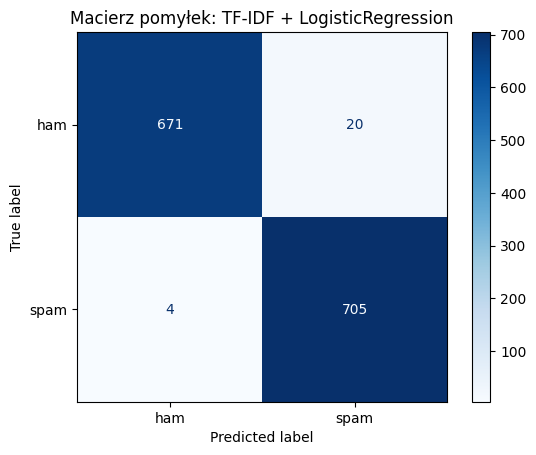

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(test_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
disp.plot(cmap="Blues")
plt.title("Macierz pomyłek: TF-IDF + LogisticRegression")
plt.show()

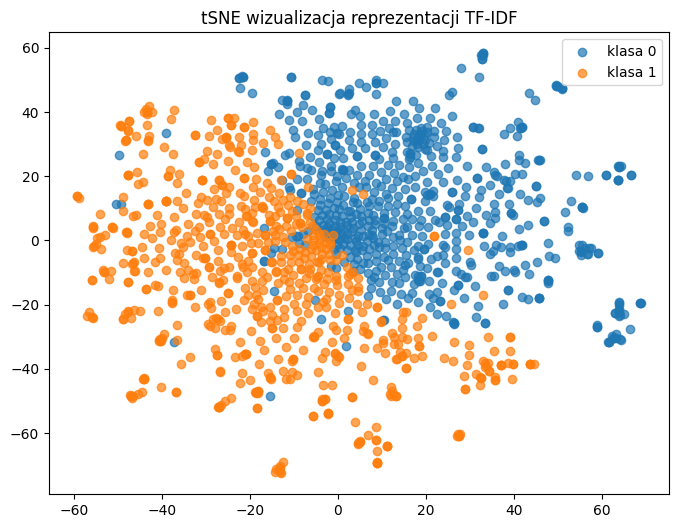

In [ ]:
from sklearn.manifold import TSNE
X_test_tfidf = pipeline.named_steps['tfidfvectorizer'].transform(test_texts)
embeddings = X_test_tfidf.toarray()

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
for label in np.unique(test_labels):
    idxs = np.array(test_labels) == label
    plt.scatter(emb_2d[idxs, 0], emb_2d[idxs, 1], label=f"klasa {label}", alpha=0.7)
plt.legend()
plt.title("tSNE wizualizacja reprezentacji TF-IDF")
plt.show()

# Model kodujący: DistilBERT

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import torch

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

def tokenize(example):
    return tokenizer(example["text"], truncation=True)

tokenized_train = train_dataset.map(tokenize, batched=True)
tokenized_val = val_dataset.map(tokenize, batched=True)
tokenized_test = test_dataset.map(tokenize, batched=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


args = TrainingArguments(
    output_dir="bert-spam",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=20,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none",
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/17760 [00:00<?, ? examples/s]

Map:   0%|          | 0/4441 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

<ipython-input-79-79c513398cd7>:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
20,0.622200
40,0.304700
60,0.137900
80,0.171900
100,0.048200
120,0.060900
140,0.053300
160,0.119800
180,0.121800
200,0.030000


TrainOutput(global_step=3330, training_loss=0.028581744697512696, metrics={'train_runtime': 2567.3503, 'train_samples_per_second': 20.753, 'train_steps_per_second': 1.297, 'total_flos': 7003957048351104.0, 'train_loss': 0.028581744697512696, 'epoch': 3.0})

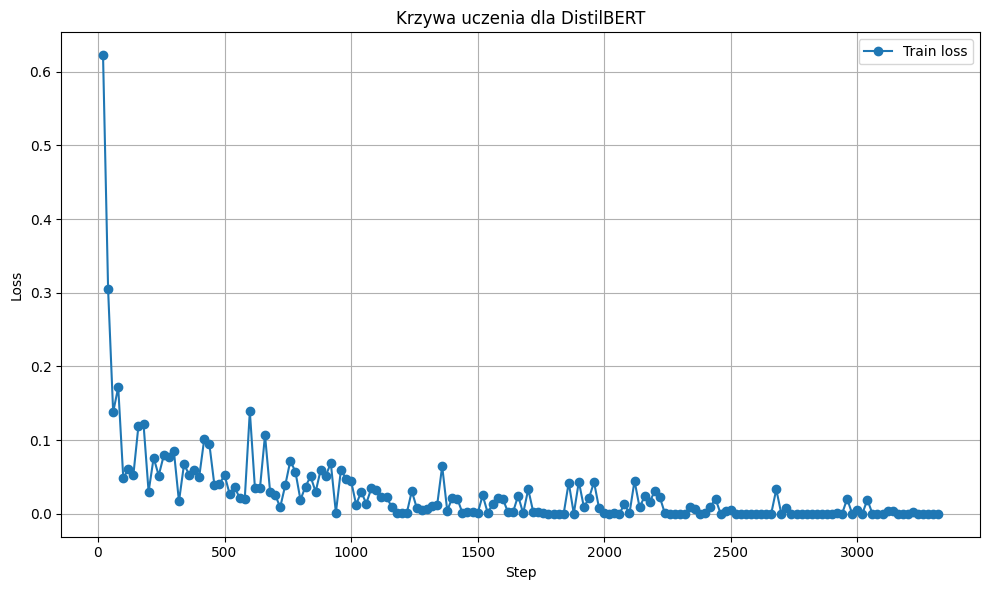

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

train_logs = [log for log in log_history if 'loss' in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

train_df = pd.DataFrame(train_logs)
eval_df = pd.DataFrame(eval_logs)

plt.figure(figsize=(10, 6))

if not train_df.empty:
    plt.plot(train_df["step"], train_df["loss"], label="Train loss", marker='o')

if not eval_df.empty:
    plt.plot(eval_df["step"], eval_df["eval_loss"], label="Validation loss", marker='x')

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Krzywa uczenia dla DistilBERT")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report

preds = trainer.predict(tokenized_test)
pred_labels = preds.predictions.argmax(-1)

true_labels = list(tokenized_test["label"])

print("BERT klasyfikator:")
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Dokładność (accuracy): {accuracy:.4f}\n")
print(classification_report(true_labels, pred_labels, target_names=["ham", "spam"]))


BERT klasyfikator:
Dokładność (accuracy): 0.9936

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       691
        spam       1.00      0.99      0.99       709

    accuracy                           0.99      1400
   macro avg       0.99      0.99      0.99      1400
weighted avg       0.99      0.99      0.99      1400



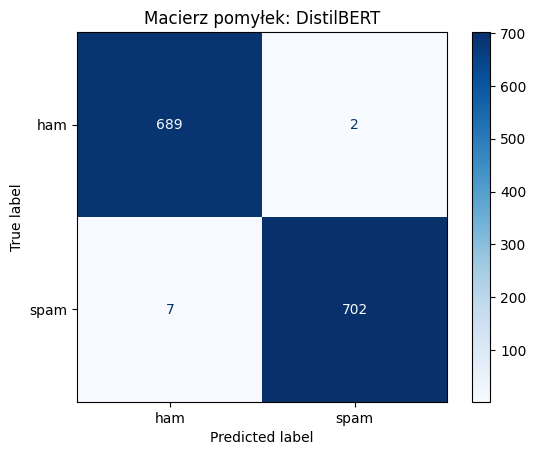

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
disp.plot(cmap="Blues")
plt.title("Macierz pomyłek: DistilBERT")
plt.show()

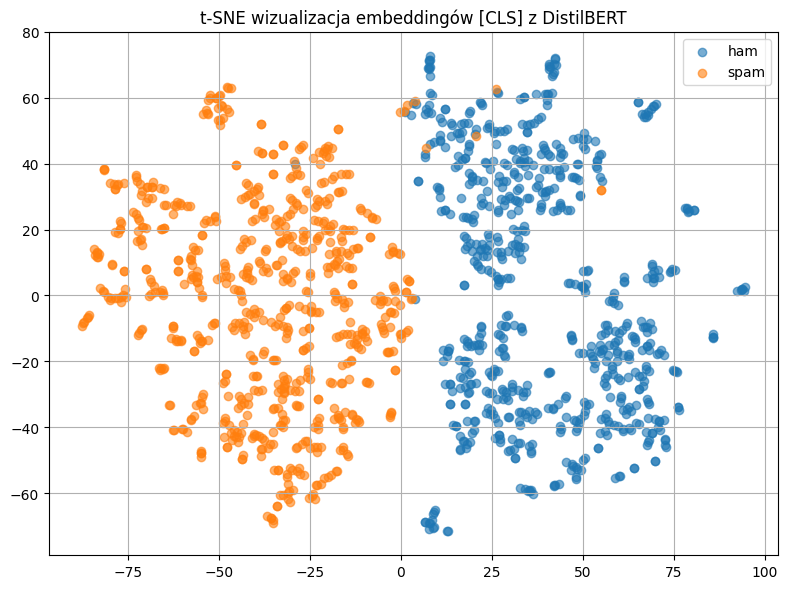

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

def get_cls_embeddings(tokenized_dataset, model, tokenizer, device):
    model.eval()
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    dataloader = DataLoader(tokenized_dataset, batch_size=16, collate_fn=data_collator)

    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            label = batch["labels"].cpu().numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
            last_hidden = outputs.hidden_states[-1]
            cls_embeddings = last_hidden[:, 0, :]

            embeddings.append(cls_embeddings.cpu().numpy())
            labels.extend(label)

    embeddings = np.vstack(embeddings)
    labels = np.array(labels)
    return embeddings, labels


tokenized_test_clean = tokenized_test.remove_columns(
    [col for col in tokenized_test.column_names if not col in ["input_ids", "attention_mask", "label"]]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

embeddings, labels = get_cls_embeddings(tokenized_test_clean, model, tokenizer, device)

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
reduced = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
for label in np.unique(labels):
    idxs = labels == label
    plt.scatter(reduced[idxs, 0], reduced[idxs, 1], label=f"klasa {label}", alpha=0.6)
plt.title("t-SNE wizualizacja embeddingów [CLS] z DistilBERT")
plt.legend(["ham", "spam"])
plt.grid(True)
plt.tight_layout()
plt.show()


# Model generatywny: Phi-1.5

In [ ]:
def convert_to_prompt(example):
    label_text = "tak" if example["label"] == 1 else "nie"
    return {
        "text": f"### Instrukcja:\nCzy to jest spam?\n\n### Wiadomość:\n{example['text']}\n\n### Odpowiedź:\n{label_text}",
        "labels": label_text
    }

formatted_train = train_dataset.map(convert_to_prompt)
formatted_val = val_dataset.map(convert_to_prompt)

Map:   0%|          | 0/17760 [00:00<?, ? examples/s]

Map:   0%|          | 0/4441 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "microsoft/phi-1_5"
gpt_tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

bnb_config = BitsAndBytesConfig(load_in_8bit=True)
gpt_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

def tokenize_function(example):
    inputs = gpt_tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)
    with gpt_tokenizer.as_target_tokenizer():
        labels = gpt_tokenizer(example["labels"], padding="max_length", truncation=True, max_length=5)
    inputs["labels"] = labels["input_ids"]
    return inputs

tokenized_train = formatted_train.map(tokenize_function, batched=True)
tokenized_val = formatted_val.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

Map:   0%|          | 0/17760 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/4441 [00:00<?, ? examples/s]

## Model generatywny: Phi-1.5 z zastosowaniem metody in-context-learning

In [ ]:
import random

def build_incontext_prompt(train_data, test_example, k=3):
    few_shot_examples = random.sample(list(train_data), k)

    prompt = ""
    for i, ex in enumerate(few_shot_examples):
        label_text = "tak" if ex["label"] == 1 else "nie"
        prompt += (
            f"### Instrukcja:\n"
            f"Czy to jest spam?\n\n"
            f"### Wiadomość:\n{ex['text'].strip()}\n\n"
            f"### Odpowiedź:\n{label_text}\n\n"
        )

    prompt += (
        f"### Instrukcja:\n"
        f"Czy to jest spam?\n\n"
        f"### Wiadomość:\n{test_example['text'].strip()}\n\n"
        f"### Odpowiedź:\n"
    )

    return prompt

def run_incontext_learning(model, gpt_tokenizer, train_dataset, test_dataset, k=3, n=5):
    model.eval()
    results = []

    for i in range(n):
        test_example = test_dataset[i]
        true_label = "spam" if test_example["label"] == 1 else "ham"

        prompt = build_incontext_prompt(train_dataset, test_example, k=k)

        inputs = gpt_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2040).to(model.device)

        with torch.no_grad():
          output = model.generate(
              **inputs,
              max_new_tokens=2,
              eos_token_id=gpt_tokenizer.eos_token_id,
              pad_token_id=gpt_tokenizer.eos_token_id,
          )

        decoded = gpt_tokenizer.decode(output[0], skip_special_tokens=True).lower()

        input_len = inputs["input_ids"].shape[1]
        new_tokens = output[0][input_len:]
        generated_answer = gpt_tokenizer.decode(new_tokens, skip_special_tokens=True).strip().lower()


        GREEN = "\033[92m"
        RESET = "\033[0m"

        if i < 5:
          print(f"\nPrzykład {i + 1}:")
          print(f"Wiadomość: {test_example['text']}")
          print(f"Odpowiedź modelu: \n {GREEN} {generated_answer} {RESET}")


        if any(word in generated_answer for word in ["nie", "ham", "nie jest spamem"]):
          pred = "ham"
        elif any(word in generated_answer for word in ["tak", "spam"]):
          pred = "spam"
        else:
            continue

        results.append((test_example["text"], true_label, pred, generated_answer))

    return results

results = run_incontext_learning(gpt_model, gpt_tokenizer, train_dataset, test_dataset, k=5, n=1000)



Przykład 1:
Wiadomość: expande tu imagen ! ! ! ! ! ! ! ! ! si no puede ver este mail , entre a : http : / / www . supermedios . com / admin / mailing / proyecto . php ? id = 160
este mensaje se enva bajo los artculos 2 y 4 de la ley
19 . 628 y 28 b de la ley 19 . 955 de la constitucin de la repblica
de chile actualizada el 14 de julio 2004 . su direccin ha sido extrada
manualmente por personal de nuestra compaa desde su sitio
web en internet , o ha sido introducida por usted al aceptar el envo
de mensajes publicitarios al inscribirse en alguno de los sitios o foros
de nuestra red de trabajo .
para ser removido presione borrar
Odpowiedź modelu: 
  nie 

Przykład 2:
Wiadomość: paliourg learning for life enlarge your member
zenextend enlargement pills
we offer the
best
male augmentation
on
the
web
success
is
guaranteed
or
receive
a
full refund
check us out
and improve
your quality
of
life
click here for more info
no ineesed ?
click hee
Odpowiedź modelu: 
  nie 

Przykład 3:
Wiadomość: cu

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

true_labels = [label for _, label, _, _ in results]
pred_labels = [pred for _, _, pred, _ in results]

print("Wyniki po in-context learning:")
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Dokładność (accuracy): {accuracy:.4f}\n")
print(classification_report(true_labels, pred_labels, target_names=["ham", "spam"]))

Wyniki po in-context learning:
Dokładność (accuracy): 0.5445

              precision    recall  f1-score   support

         ham       0.56      0.51      0.53       246
        spam       0.53      0.58      0.55       237

    accuracy                           0.54       483
   macro avg       0.55      0.55      0.54       483
weighted avg       0.55      0.54      0.54       483



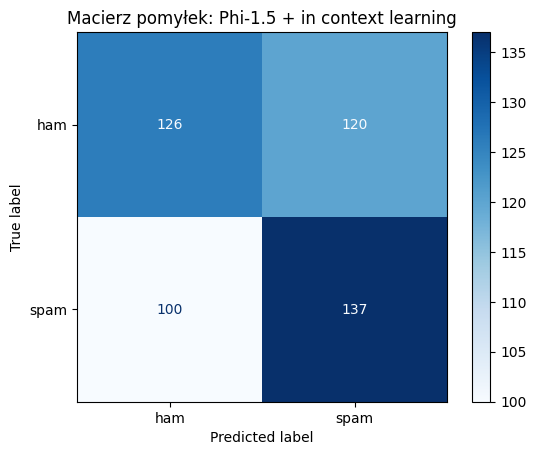

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(true_labels, pred_labels, labels=["ham", "spam"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
disp.plot(cmap="Blues")
plt.title("Macierz pomyłek: Phi-1.5 + in context learning")
plt.show()

## Model generatywny: Phi-1.5 z LoRA

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)

In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForLanguageModeling

peft_model = get_peft_model(gpt_model, peft_config)
peft_model.config.use_cache = False

training_args = TrainingArguments(
    output_dir="./phi-qlora",
    warmup_steps=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    max_steps=2000,
    learning_rate=2.5e-5,
    lr_scheduler_type="cosine",
    optim="paged_adamw_8bit",
    logging_dir="./logs",
    logging_steps=20,
    eval_steps=50,
    do_eval=True,
    report_to="none"
)

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=gpt_tokenizer,
    data_collator=DataCollatorForLanguageModeling(gpt_tokenizer, mlm=False)
)

trainer.train()
peft_model.config.use_cache = True

<ipython-input-57-22642c858c81>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
20,4.154100
40,3.964700
60,3.752700
80,3.618900
100,3.348000
120,3.134700
140,3.176600
160,3.045100
180,3.208300
200,3.317400


Dostępne klucze w logach: {'total_flos', 'epoch', 'loss', 'train_runtime', 'learning_rate', 'train_samples_per_second', 'train_loss', 'grad_norm', 'step', 'train_steps_per_second'}


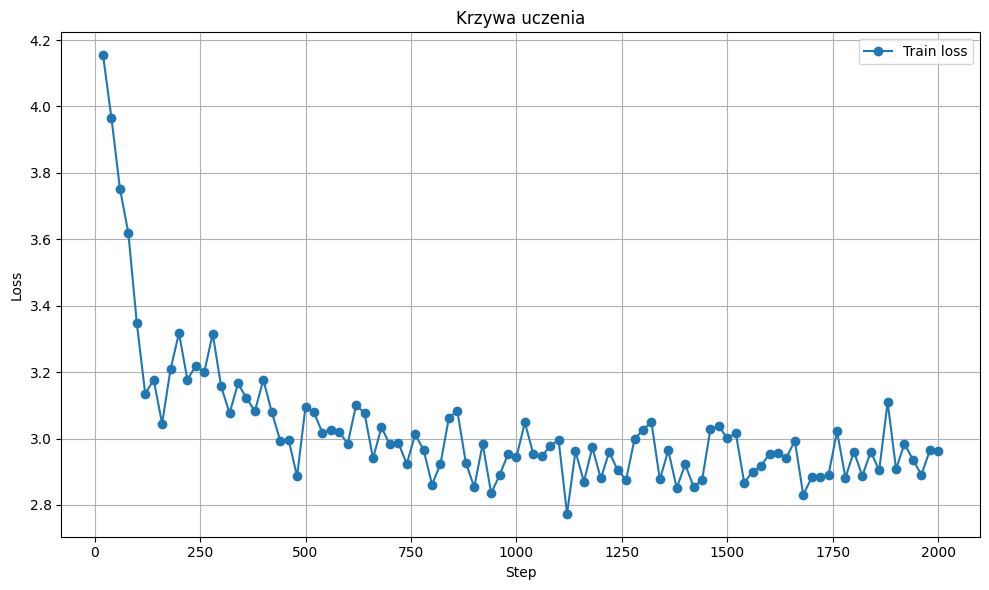

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

all_keys = set()
for log in log_history:
    all_keys.update(log.keys())
print("Dostępne klucze w logach:", all_keys)

train_logs = [log for log in log_history if "loss" in log and "eval" not in log]
eval_logs = [log for log in log_history if any(k.startswith("eval_loss") for k in log.keys())]

train_df = pd.DataFrame(train_logs)
eval_df = pd.DataFrame(eval_logs)

plt.figure(figsize=(10, 6))

if not train_df.empty and "loss" in train_df.columns:
    plt.plot(train_df["step"], train_df["loss"], label="Train loss", marker="o")

eval_loss_col = None
if not eval_df.empty:
    for col in eval_df.columns:
        if col.startswith("eval_loss"):
            eval_loss_col = col
            break

if eval_loss_col and not eval_df.empty:
    plt.plot(eval_df["step"], eval_df[eval_loss_col], label="Validation loss", marker="x")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Krzywa uczenia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import random

def format_prompt_for_inference(text):
    return (
        "### Instrukcja:\n"
        "Czy to jest spam?\n\n"
        "### Wiadomość:\n"
        f"{text}\n\n"
        "### Odpowiedź:\n"
    )

peft_model.eval()

examples = random.sample(list(test_dataset), 1000)
true_labels = []
pred_labels = []

for num in range(1000):
      true_label = "spam" if examples[num]["label"] == 1 else "ham"

      prompt = format_prompt_for_inference(examples[num]["text"])
      inputs = gpt_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2040).to(peft_model.device)

      outputs = peft_model.generate(
          **inputs,
          max_new_tokens=2,
          eos_token_id=gpt_tokenizer.eos_token_id,
          pad_token_id=gpt_tokenizer.eos_token_id,
      )

      input_len = inputs["input_ids"].shape[1]
      new_tokens = outputs[0][input_len:]
      generated_answer = gpt_tokenizer.decode(new_tokens, skip_special_tokens=True).strip().lower()


      GREEN = "\033[92m"
      RESET = "\033[0m"

      if num < 5:
        print(f"\nPrzykład {num + 1}:")
        print(f"Wiadomość: {examples[num]['text']}")
        print(f"Odpowiedź modelu: {GREEN} \n {generated_answer} {RESET}")

      num += 1
      if any(word in generated_answer for word in ["nie", "ham", "nie jest spamem"]):
          pred_label = "ham"
      elif any(word in generated_answer for word in ["tak", "spam"]):
          pred_label = "spam"
      else:
          continue

      true_labels.append(true_label)
      pred_labels.append(pred_label)



Przykład 1:
Wiadomość: bu " y cia , lis soft ' tabs online for less ` . viagra ' s newest and best rival cialls has been around for a while
now available in softtabs
save 70 % +
shipped world wide ( anywhere )
no prescription neccesary
more | nfo here
rem . . 0 ve me
Odpowiedź modelu:  
 tak 

Przykład 2:
Wiadomość: double coverage amount , same payment . . . uyz save up to
75 % on your term life
insurance !
compare rates from top insurance companies around
the country
in our life and times , it ' s important to plan for
your family ' s future , while
being comfortable financially . choose the right
life insurance policy today .
click the link below to compare the lowest rates
and save up to 75 %
compare your coverage
you ' ll be able to compare rates and get a free
application in less than a minute !
* get your free instant quotes . . .
* compare the lowest prices , then . . .
* select a company and apply online .
get a free quote now !
you can ' t predict the future , but you can al

In [ ]:
print("Wyniki po dostrojeniu LoRA:")
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Dokładność (accuracy): {accuracy:.4f}\n")
print(classification_report(true_labels, pred_labels, target_names=["ham", "spam"]))

Wyniki po dostrojeniu LoRA:
Dokładność (accuracy): 0.9376

              precision    recall  f1-score   support

         ham       0.94      0.93      0.94       495
        spam       0.93      0.94      0.94       482

    accuracy                           0.94       977
   macro avg       0.94      0.94      0.94       977
weighted avg       0.94      0.94      0.94       977



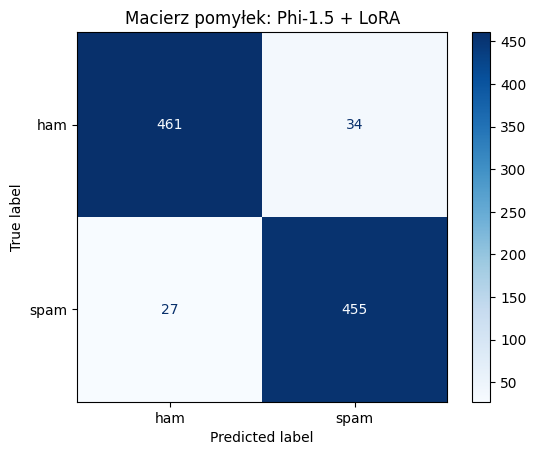

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(true_labels, pred_labels, labels=["ham", "spam"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
disp.plot(cmap="Blues")
plt.title("Macierz pomyłek: Phi-1.5 + LoRA")
plt.show()

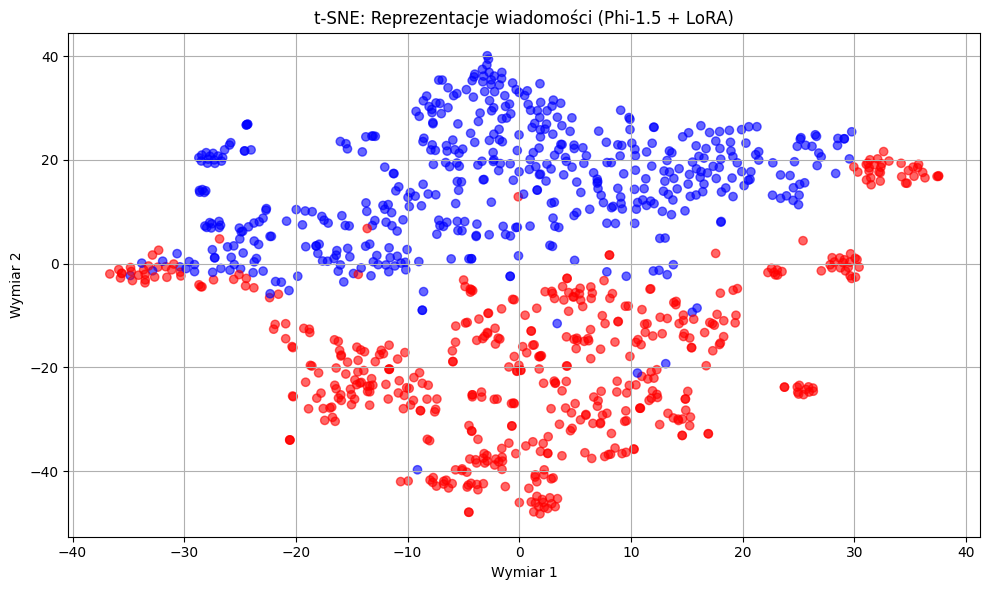

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

test_texts = [e["text"] for e in test_dataset]
true_labels_2 = ["spam" if e["label"] == 1 else "ham" for e in test_dataset]
sample_texts = test_texts[:1000]
sample_labels = true_labels_2[:1000]

embeddings = []

peft_model.eval()
for text in sample_texts:
    prompt = format_prompt_for_inference(text)
    inputs = gpt_tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(peft_model.device)

    with torch.no_grad():
        outputs = peft_model(**inputs, output_hidden_states=True)

    last_hidden = outputs.hidden_states[-1]
    mean_embedding = last_hidden.mean(dim=1).squeeze().cpu().numpy()
    embeddings.append(mean_embedding)

embeddings = np.array(embeddings)

tsne = TSNE(n_components=2, perplexity=min(30, len(embeddings)-1), random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

label_colors = {"ham": "blue", "spam": "red"}
colors = [label_colors[label] for label in sample_labels]

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.6)
plt.title("t-SNE: Reprezentacje wiadomości (Phi-1.5 + LoRA)")
plt.xlabel("Wymiar 1")
plt.ylabel("Wymiar 2")
plt.grid(True)
plt.tight_layout()
plt.show()
